In [21]:
mode = "png"

import matplotlib

font = {'family' : 'Dejavu Sans',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

import matplotlib
from matplotlib import pyplot as plt

In [22]:
from graspologic.simulations import sbm
import numpy as np
from sklearn.preprocessing import LabelEncoder

n = 100  # the number of nodes
M = 8  # the total number of networks
# human brains have homophilic block structure
Bhuman = np.array([[0.4, 0.02], [0.02, 0.4]])
# alien brains have a core-periphery block structure
Balien = np.array([[0.3, 0.1], [0.1, 0.05]])

# set seed for reproducibility
np.random.rand(123)
# generate 4 human and alien brain networks
A_humans = [sbm([n // 2, n // 2], Bhuman) for i in range(M // 2)]
A_aliens = [sbm([n // 2, n // 2], Balien) for i in range(M // 2)]
# concatenate list of human and alien networks
networks = A_humans + A_aliens

# 1 = left hemisphere, 2 = right hemisphere for node communities
le = LabelEncoder()
labels = np.repeat(["L", "R"], n//2)
zs = le.fit_transform(labels) + 1

/tmp/ipykernel_78271/3772275799.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


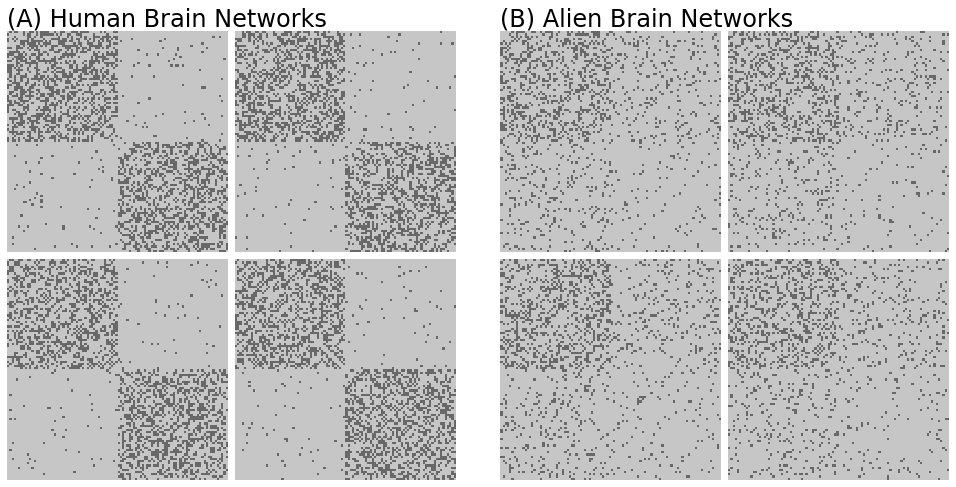

In [23]:
from mpl_toolkits.axes_grid1 import ImageGrid
from graphbook_code import heatmap

fig = plt.figure(figsize=(14,7))

grid1 = ImageGrid(fig, 121, (2, 2), axes_pad=.1, share_all=True)
grid2 = ImageGrid(fig, 122, (2, 2), axes_pad=.1, share_all=True)

for i, (axi, axj) in enumerate(zip(grid1, grid2)):
    hmn = heatmap(A_humans[i].astype(int), ax=axi, cbar=False)
    hma = heatmap(A_aliens[i].astype(int), ax=axj, cbar=False)

grid1.axes_all[0].set_title("(A) Human Brain Networks", fontsize=24, y=1, loc="left")
grid2.axes_all[0].set_title("(B) Alien Brain Networks", fontsize=24, y=1, loc="left")
fig.tight_layout()
fig.savefig("Figures/multi_ex.{}".format(mode))

In [24]:
from graspologic.embed import AdjacencySpectralEmbed as ase

# embed the first network with a seed for reproducibility
Xhat = ase(n_components=2, svd_seed=123).fit_transform(A_humans[0])

In [25]:
# a rotation by 90 degrees
W = np.array([[0, -1], [1, 0]])
Yhat = Xhat @ W

# check that probability matrix is the same
np.allclose(Yhat @ Yhat.transpose(), Xhat @ Xhat.transpose())
# returns True

True

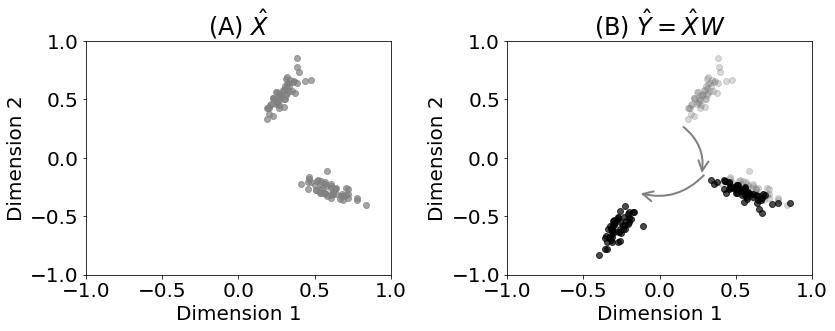

In [29]:
from matplotlib import patches
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(Xhat[:,0], Xhat[:,1], color="gray", alpha=0.7)
axs[0].set_xlim([-1,1])
axs[0].set_ylim([-1,1])
axs[0].set_title("(A) $\\hat X$")
axs[0].set_xlabel("Dimension 1")
axs[0].set_ylabel("Dimension 2")

arrow_dat = {}
for z in np.unique(zs):
    center_unrot = Xhat[zs == z,:].mean(axis=0)
    center_rot = Yhat[zs == z,:].mean(axis=0)
    arrow_dat[z] = {"unrot": center_unrot, "rot": center_rot}

axs[1].scatter(Xhat[:,0], Xhat[:,1], color="gray", alpha=0.3)
axs[1].scatter(Yhat[:,0], Yhat[:,1], color="black", alpha=0.7)
axs[1].set_xlim([-1,1])
axs[1].set_ylim([-1,1])
axs[1].set_title("(B) $\\hat Y = \\hat X W$")
axs[1].set_xlabel("Dimension 1")
axs[1].set_ylabel("Dimension 2")

style = "->, head_length=10, head_width=5, scaleB=10, scaleA=10"
kw = dict(arrowstyle=style, color="gray", linewidth="2")

for z in arrow_dat.keys():
    arrow = arrow_dat[z]
    axs[1].add_patch(patches.FancyArrowPatch(arrow["unrot"]*.5, arrow["rot"]*.5, connectionstyle="arc3,rad=-.3", **kw))

fig.tight_layout()
fig.savefig("Figures/rotation.{}".format(mode))

In [35]:
# embed the second network
Xhat2 = ase(n_components=2).fit_transform(A_humans[2])

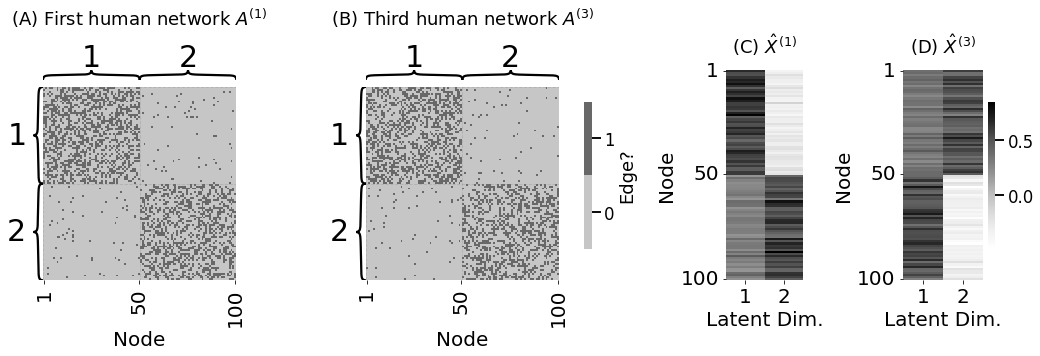

In [42]:
from graphbook_code import lpm_heatmap

fig, axs = plt.subplots(1, 4, figsize=(15, 5), gridspec_kw = {"width_ratios": [1, 1.27, .35, .45]})

heatmap(A_humans[0].astype(int), cbar=False, ax=axs[0],
        xticks=[0.5, 49.5, 99.5], xticklabels=[1, 50, 100], xtitle="Node",
        inner_hier_labels=zs, title="(A) First human network $A^{(1)}$")
heatmap(A_humans[1].astype(int), legend_title="Edge?", ax=axs[1],
        xticks=[0.5, 49.5, 99.5], xticklabels=[1, 50, 100], xtitle="Node",
        inner_hier_labels=zs, title="(B) Third human network $A^{(3)}$")

vmin = np.min([Xhat, Xhat2]); vmax = np.max([Xhat, Xhat2])
lpm_heatmap(Xhat, xtitle="Latent Dim.", xticks=[0.5, 1.5], xticklabels=[1, 2],
            yticks=[0.5, 49.5, 99.5], yticklabels=[1, 50, 100], ytitle="Node",
            ax=axs[2], cbar=False, vmin=vmin, vmax=vmax, title="(C) $\\hat X^{(1)}$")
lpm_heatmap(Xhat2, xtitle="Latent Dim.", xticks=[0.5, 1.5], xticklabels=[1, 2],
            yticks=[0.5, 49.5, 99.5], yticklabels=[1, 50, 100], ytitle="Node",
            ax=axs[3], vmin=vmin, vmax=vmax, title="(D) $\\hat X^{(3)}$", shrink=0.7)

fig.tight_layout()
fig.savefig("Figures/cmp_identical.{}".format(mode))

In [43]:
# embed the first alien network
Xhat_alien = ase(n_components=2).fit_transform(A_aliens[0])

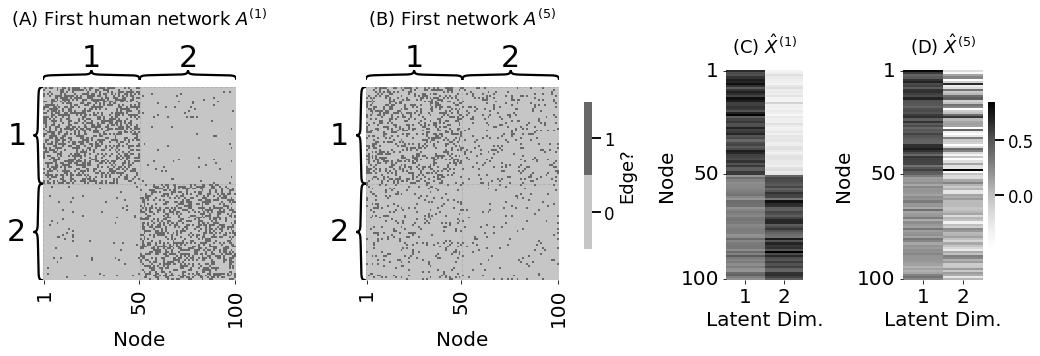

In [45]:

fig, axs = plt.subplots(1, 4, figsize=(15, 5), gridspec_kw = {"width_ratios": [1, 1.27, .35, .45]})

heatmap(A_humans[0].astype(int), cbar=False, ax=axs[0],
        xticks=[0.5, 49.5, 99.5], xticklabels=[1, 50, 100], xtitle="Node",
        inner_hier_labels=zs, title="(A) First human network $A^{(1)}$")
heatmap(A_aliens[0].astype(int), legend_title="Edge?", ax=axs[1],
        xticks=[0.5, 49.5, 99.5], xticklabels=[1, 50, 100], xtitle="Node",
        inner_hier_labels=zs, title="(B) First alien network $A^{(5)}$")

vmin = np.min([Xhat, Xhat2]); vmax = np.max([Xhat, Xhat2])
lpm_heatmap(Xhat, xtitle="Latent Dim.", xticks=[0.5, 1.5], xticklabels=[1, 2],
            yticks=[0.5, 49.5, 99.5], yticklabels=[1, 50, 100], ytitle="Node",
            ax=axs[2], cbar=False, vmin=vmin, vmax=vmax, title="(C) $\\hat X^{(1)}$")
lpm_heatmap(Xhat_alien, xtitle="Latent Dim.", xticks=[0.5, 1.5], xticklabels=[1, 2],
            yticks=[0.5, 49.5, 99.5], yticklabels=[1, 50, 100], ytitle="Node",
            ax=axs[3], vmin=vmin, vmax=vmax, title="(D) $\\hat X^{(5)}$", shrink=0.7)

fig.tight_layout()
fig.savefig("Figures/cmp_diss.{}".format(mode))

In [50]:

# compute frob norm between first human and third human net
# estimated latent positions
dist_firsthum_thirdhum = np.linalg.norm(Xhat - Xhat2, ord="fro")
print("Frob. norm(first human, third human) = {:3f}".format(dist_firsthum_thirdhum))
#

# compute frob norm between first human and first alien net
# estimated latent positions
dist_firsthum_alien = np.linalg.norm(Xhat - Xhat_alien, ord="fro")
print("Frob. norm(first human, alien) = {:3f}".format(dist_firsthum_alien))

Frob. norm(first human, third human) = 8.779884
Frob. norm(first human, alien) = 5.209303


In [ ]:
fig.tight_layout()
fig.savefig("Figures/.{}".format(mode))